In [1]:
!pip install torcheval

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.7 MB/s eta 0:00:00


In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import zipfile
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision import models
from torch.utils.data import random_split
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from torcheval.metrics import MulticlassAUROC
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
# Dowload the dataset
dataset_url = "https://github.com/shrish23/Footprint-Classification/archive/refs/heads/master.zip"
download_url(dataset_url, '.')


with zipfile.ZipFile('./master.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

DATA_DIR = './data/Footprint-Classification-master/Train'
print(os.listdir(DATA_DIR))

161572290it [00:06, 23478211.90it/s]


['Leopard', 'Dog', 'elephant', 'Bird', 'Cat', 'boar', 'Bear', 'Otter']


In [4]:
for fname in os.listdir(DATA_DIR):
    print(fname)

Leopard
Dog
elephant
Bird
Cat
boar
Bear
Otter


In [5]:
dataset = ImageFolder(DATA_DIR)

In [6]:
len(dataset)

1675

In [7]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=2983x3927>, 0)

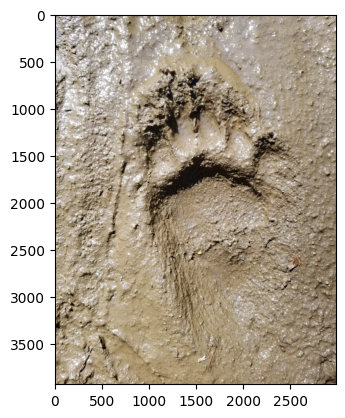

In [8]:
img, label = dataset[0]
plt.imshow(img)

In [9]:
stats = ([0.485, 0.456, 0.406], [0.229,0.224,0.225])
img_size=224

In [10]:
dataset = ImageFolder(DATA_DIR,T.Compose([
    T.Resize(224),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(),
    T.ToTensor(),
    T.Normalize(*stats),
]))

In [11]:
len(dataset)

1675

In [12]:
dataset.classes

['Bear', 'Bird', 'Cat', 'Dog', 'Leopard', 'Otter', 'boar', 'elephant']

In [13]:
dataset[0][0].shape

torch.Size([3, 224, 224])

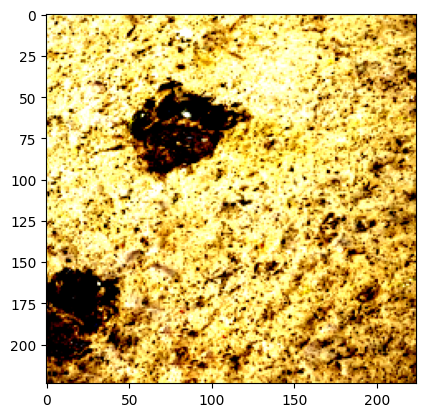

In [14]:
img, label = dataset[5]
plt.imshow(img.permute(1,2,0))

In [15]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label: ',dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor,*stats)[0].permute((1,2,0))
    plt.imshow(img_tensor)

Label:  Bear (0)


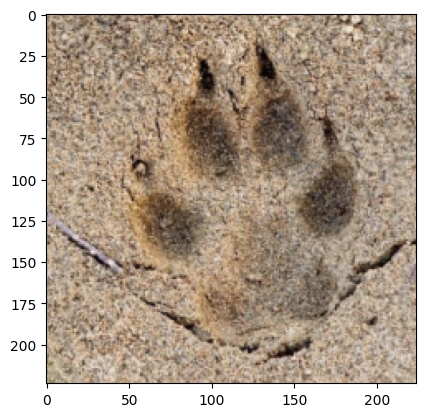

In [16]:
show_image(*dataset[56])

# Creating Training and Validation Sets

In [17]:
val_pct = 0.1
test_pct = 0.1
val_size = int(val_pct * len(dataset))
test_size = int(test_pct * len(dataset))
train_size = len(dataset) - val_size - test_size


train_ds, val_ds, test_ds = random_split(dataset,[train_size,val_size,test_size])
len(train_ds),len(val_ds),len(test_ds)

(1341, 167, 167)

In [18]:
batch_size = 16

train_dl = DataLoader(train_ds, batch_size, shuffle=True,num_workers=4,pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size, num_workers=4,pin_memory=True)

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

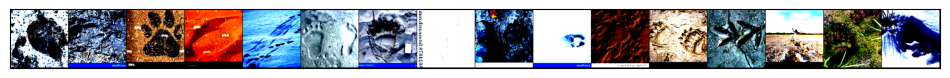

In [20]:
show_batch(train_dl)

# Modifying a Pretrained Model

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
img, label = dataset[2]
img.shape

torch.Size([3, 224, 224])

In [24]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss':loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

In [26]:
class FootprintsModel(ImageClassificationBase):
    def __init__(self,num_classes,pretrained=True):
        super().__init__()
#         self.network = models.vit_l_16(weights=models.ViT_L_16_Weights.DEFAULT)

#         self.network.conv_proj = nn.Conv2d(1, 1024, kernel_size=(16, 16), stride=(16, 16))
#         self.network = models.vit_l_16(weights=models.ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)
#         self.resnet152 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
#         self.resnet101 = models.resnext101_64x4d(weights=models.ResNeXt101_64X4D_Weights.IMAGENET1K_V1)
#         self.resnet152_part = nn.Sequential(*list(self.resnet152.children())[:-3])
#         self.resnet101_part = nn.Sequential(*list(self.resnet101.children())[-3:])
#         self.network = nn.Sequential(self.resnet152_part,self.resnet101_part)
        self.network=models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
#         self.network = models.resnext101_64x4d(weights=models.ResNeXt101_64X4D_Weights.IMAGENET1K_V1)
#         self.network = models.regnet_y_128gf(weights=models.RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_LINEAR_V1)
#         self.network = models.regnet_x_32gf(weights=models.RegNet_X_32GF_Weights.IMAGENET1K_V2)
        self.network.fc = nn.Linear(self.network.fc.in_features,num_classes)
#         self.network[1][2] = nn.Linear(self.network[1][2].in_features,num_classes)
#         self.network.heads.head = nn.Linear(self.network.heads.head.in_features,num_classes)
#         self.network = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
#         self.network.classifier = nn.Sequential(
#             nn.Dropout(p=0.4, inplace=True),
#             nn.Linear(in_features=1280,out_features=num_classes,bias=True)
#         )

    def forward(self,xb):
        return self.network(xb)

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()#tells the model that we are evaluating and not training, so dropout is turned off
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,
                 weight_decay=0,grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    #Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training the model
        model.train()
        train_losses=[]
        lrs=[]
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            #Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            #Record and update the learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        #Validation step
        result = evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def fit(epochs, lr, model, train_loader, val_loader,opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #Training phase
        model.train()
        train_losses=[]
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# Finetuning the Pretrained Model

In [28]:
# def conv_block(in_channels,out_channels,pool=False):
#     layers = [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
#              nn.BatchNorm2d(out_channels),
#              nn.ReLU()]
#     if pool: layers.append(nn.MaxPool2d(2))
#     return nn.Sequential(*layers)

# class ResNet9(ImageClassificationBase):
#     def __init__(self,in_channels,num_classes):
#         super().__init__()
#         #128 x 3 x 224 x 224
#         self.conv1 = conv_block(in_channels,64)# 64 x 224 x 224
#         self.conv2 = conv_block(64,128,pool=True)# 128 x 112 x 112
#         self.res1 = nn.Sequential(conv_block(128,128),
#                                  conv_block(128,128))

#         self.conv3 = conv_block(128,256,pool=True)# 256 x 56 x 56
#         self.conv4 = conv_block(256,512,pool=True)# 512 x 28 x 28
#         self.res2 = nn.Sequential(conv_block(512,512),
#                                  conv_block(512,512))

#         self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
#                                        nn.Flatten(),
#                                        nn.Dropout(0.2),
#                                        nn.Linear(512,num_classes))

#     def forward(self, xb):
#         out = self.conv1(xb)
#         out = self.conv2(out)
#         out = self.res1(out) + out
#         out = self.conv3(out)
#         out = self.conv4(out)
#         out = self.res2(out) + out
#         out = self.classifier(out)
#         return out

In [29]:
model = to_device(FootprintsModel(len(dataset.classes)),device)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:03<00:00, 65.4MB/s]


In [30]:
for batch in train_dl:
    images, labels = batch
    print('images.shape: ',images.shape)
    print(images.device)
    preds = model(images)
    print('preds.shape: ',preds.shape)
    print(preds)
    break

images.shape:  torch.Size([16, 3, 224, 224])
cuda:0
preds.shape:  torch.Size([16, 8])
tensor([[-0.1347,  0.1106, -0.1203,  0.4904, -0.0189,  0.3498, -0.0107,  0.0254],
        [ 0.1374,  0.3271,  0.0993, -0.0955, -0.2343,  0.2530,  0.0909, -0.1936],
        [ 0.1010, -0.0950,  0.1715,  0.1058, -0.0461,  0.0536, -0.0514,  0.1237],
        [-0.1950,  0.2229, -0.0825,  0.0171, -0.2441,  0.4080,  0.0996,  0.0095],
        [ 0.2402, -0.0070, -0.3041,  0.1600,  0.0932,  0.4329,  0.0623, -0.1586],
        [-0.0266,  0.0893,  0.0905,  0.0106,  0.0090,  0.0644, -0.0347,  0.0651],
        [ 0.2007, -0.1280,  0.2637,  0.1790, -0.3682,  0.3681, -0.1980, -0.0572],
        [ 0.2495,  0.1127,  0.0247,  0.1606, -0.0885,  0.0655, -0.2490, -0.1861],
        [-0.0044,  0.0294,  0.0571,  0.2328,  0.0439,  0.0250,  0.0416, -0.0218],
        [ 0.2201,  0.1539,  0.0616,  0.0295, -0.2059,  0.1497,  0.0039,  0.0424],
        [ 0.1809,  0.0189,  0.0913,  0.3217,  0.2552,  0.1499, -0.0496,  0.0995],
        [ 0.

In [31]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.103853702545166, 'val_acc': 0.09090909361839294}]

In [32]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam
# These will give 88 % accuracy on the dataset for RESNET152

In [33]:
history += fit_one_cycle(epochs,max_lr,model,train_dl,valid_dl,weight_decay,grad_clip)

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00277, train_loss: 1.8591, val_loss: 1.6024, val_acc: 0.3937


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00758, train_loss: 1.2217, val_loss: 1.1601, val_acc: 0.6372


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.01000, train_loss: 0.8020, val_loss: 1.0890, val_acc: 0.6226


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00950, train_loss: 0.5065, val_loss: 1.0853, val_acc: 0.6485


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00812, train_loss: 0.3592, val_loss: 0.8895, val_acc: 0.7281


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00611, train_loss: 0.2277, val_loss: 0.9563, val_acc: 0.7508


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00389, train_loss: 0.1879, val_loss: 0.9347, val_acc: 0.7565


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00188, train_loss: 0.1233, val_loss: 0.8389, val_acc: 0.7963


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00050, train_loss: 0.0972, val_loss: 0.8296, val_acc: 0.8206


  0%|          | 0/84 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00000, train_loss: 0.0802, val_loss: 0.8932, val_acc: 0.7979


In [34]:
def plot_acc(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies,'-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

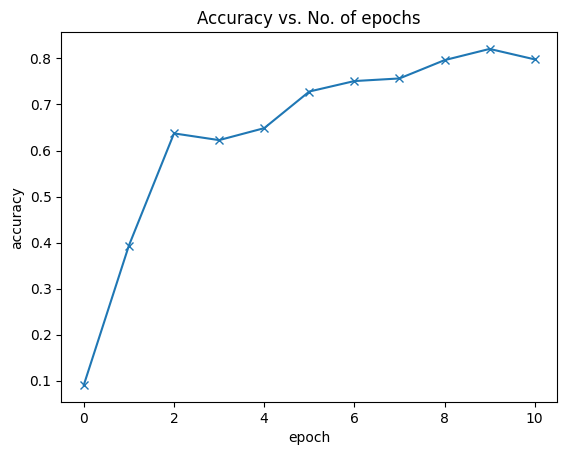

In [35]:
plot_acc(history)

# TESTING the model

In [36]:
test_dl = DataLoader(test_ds,batch_size=16)
test_dl

In [37]:
for batch in test_dl:
    images, labels = batch
    images,labels = images.cuda(),labels.cuda()
    print('images.shape: ',images.shape)
    print(images.device)
    preds = model(images)
    print('preds.shape: ',preds.shape)
    print(preds)
    break

images.shape:  torch.Size([16, 3, 224, 224])
cuda:0
preds.shape:  torch.Size([16, 8])
tensor([[-6.2400e+00,  6.9060e+00, -6.7572e+00,  2.6733e+00, -3.9819e+00,
          1.0334e+00, -2.3311e+00, -3.8542e+00],
        [-3.5399e+00, -4.6466e+00, -3.8107e+00, -2.9576e+00,  7.7048e-01,
          2.0811e-01,  3.3952e+00, -3.9530e+00],
        [-1.8330e+00, -1.0604e+00, -5.9724e+00, -2.5135e+00,  5.9581e+00,
          1.2809e+00, -7.9107e+00, -6.7196e+00],
        [-1.2987e+00,  9.5709e-01, -3.2616e+00, -4.6888e+00, -1.3570e+00,
          5.7063e+00, -3.9863e+00, -4.7586e+00],
        [-3.0129e+00,  7.1045e+00, -4.1249e+00, -1.3963e+00, -6.1254e-01,
         -1.6162e+00, -3.6545e+00, -2.2344e+00],
        [ 7.8544e+00, -1.1133e+00, -3.7855e+00, -8.7770e-01,  2.4664e-01,
         -3.5283e+00, -5.9435e+00, -4.1770e+00],
        [-3.1163e+00, -2.8364e+00,  1.3018e+00,  4.3593e+00,  8.2900e-01,
         -3.3038e+00, -3.8034e+00, -4.7745e+00],
        [-2.1534e+00, -8.4207e-01, -1.2744e+00, -3.06

### Using AOC metric 

In [38]:
metric = MulticlassAUROC(num_classes=8)

In [39]:
metric.update(preds, labels)
metric.compute()

tensor(0.8646)